In [1]:
import os
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [4]:
input_shape = (224, 224, 3)
dataset_dir = r"C:\Users\m1355\Documents\WeChat Files\wxid_z0qpzwe8erfg22\FileStorage\File\2023-06\crc_skin_data\crc_skin_data"
batch_size = 4


In [5]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # 20% of the data will be used for validation

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='training')  # Use the training subset of the data

validation_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')  # Use the validation subset of the data

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary')

# Rest of the code remains the same...


Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
def inception_block(inputs, filters):
    branch1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(inputs)
    branch1 = Conv2D(filters[1], (3, 3), padding='same', activation='relu')(branch1)

    branch2 = Conv2D(filters[2], (1, 1), padding='same', activation='relu')(inputs)
    branch2 = Conv2D(filters[3], (5, 5), padding='same', activation='relu')(branch2)

    branch3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    branch3 = Conv2D(filters[4], (1, 1), padding='same', activation='relu')(branch3)

    branch4 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(inputs)

    output = Concatenate(axis=-1)([branch1, branch2, branch3, branch4])
    return output


In [7]:
def InceptionModel(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Initial Convolution layer
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    
    # Inception Blocks
    x = inception_block(x, [16, 32, 8, 16, 8, 16])
    x = inception_block(x, [32, 64, 16, 32, 16, 32])
    x = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    x = inception_block(x, [64, 128, 32, 64, 32, 64])
    x = inception_block(x, [128, 256, 64, 128, 64, 128])
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)

    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [8]:
num_classes = 1
model = InceptionModel(input_shape, num_classes)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [9]:
history = model.fit(train_generator, epochs=2, validation_data=validation_generator, verbose=1)


Epoch 1/2
100/100 [==============================] - 31s 226ms/step - loss: 0.6996 - accuracy: 0.5325 - val_loss: 0.6640 - val_accuracy: 0.5100
Epoch 2/2
100/100 [==============================] - 22s 221ms/step - loss: 0.6587 - accuracy: 0.6250 - val_loss: 0.7666 - val_accuracy: 0.5300


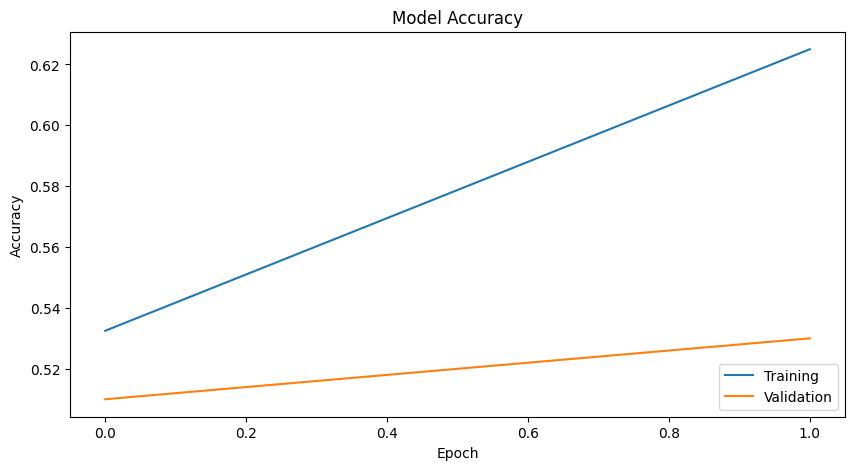

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()


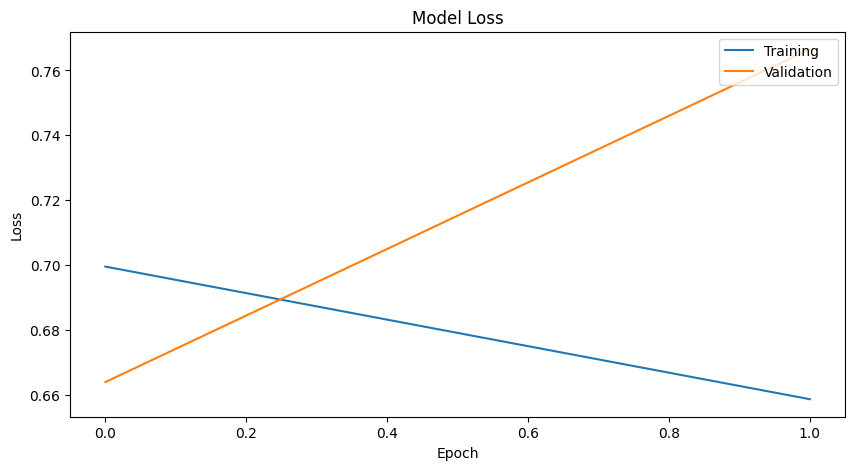

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


In [12]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

25/25 [==============================] - 2s 70ms/step - loss: 0.6940 - accuracy: 0.5600
Test Loss: 0.6940144300460815
Test Accuracy: 0.5600000023841858


In [13]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model

In [14]:
# you will need to install numba using "pip install numba"
from numba import cuda

cuda.select_device(0)
cuda.close()